In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import requests

import torch
import torch.nn as nn
from transformers import ViTModel, RobertaModel, RobertaTokenizer
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

# Data Loading and Preprocessing

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/sample.csv")
len(train_df)

54331

In [4]:
train_df = train_df.sample(frac=0.1)

In [5]:
len(train_df)

5433

In [6]:
train_df.head()

,Unnamed: 0,content,languages,image_url_status,image_url,video_thumbnail_status,video_thumbnail_url,video_url_status,video_url,video_bitrate,...,media,media_type,emoji_count,hastag_count,uppercase_count,at_count,sentiment_score,subjectivity_score,word_count,image_size
9088,9088,"Need money now? UPS is hiring Package Car, Per...",['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/EYfTDq_WkAA6rTn?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,[Photo(previewUrl='https://pbs.twimg.com/media...,image,0,0,2,0,0.00000,0.300000,34,"(680, 383)"
7817,7817,Liberals have not yet lived up to reconciliati...,['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/EpEO7wYXUAI6JQK?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,[Photo(previewUrl='https://pbs.twimg.com/media...,image,2,2,0,0,0.00000,0.000000,14,"(680, 356)"
10227,10227,Looks like Jeremy Lin could be coming back to ...,['ENGLISH'],Link exists and is accessible,https://pbs.twimg.com/media/EpiaaeEU8AEMSFt?fo...,Link does not exist,Video thumbnail does not exist,Link does not exist,Video does not exist,Does not exist,...,[Photo(previewUrl='https://pbs.twimg.com/media...,image,1,1,0,0,0.00000,0.000000,19,"(680, 453)"
18531,18531,If you’re thinking about quitting your #SmallB...,['ENGLISH'],Link does not exist,Image does not exist,Link exists and is accessible,https://pbs.twimg.com/ext_tw_video_thumb/97143...,Link exists and is accessible,https://video.twimg.com/ext_tw_video/971436591...,256000,...,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,video,4,2,1,0,0.08447,0.218182,51,"(1200, 675)"
3222,3222,A mention gets attention! \n\nLearn how @ ment...,['ENGLISH'],Link does not exist,Image does not exist,Link exists and is accessible,https://pbs.twimg.com/media/EQqyDTUXYAEzvUD.jpg,Link exists and is accessible,https://video.twimg.com/ext_tw_video/122798956...,256000,...,[Video(thumbnailUrl='https://pbs.twimg.com/med...,video,0,0,1,1,0.50000,0.500000,17,"(1200, 675)"


In [7]:
train_df.columns

Index(['Unnamed: 0', 'content', 'languages', 'image_url_status', 'image_url',
       'video_thumbnail_status', 'video_thumbnail_url', 'video_url_status',
       'video_url', 'video_bitrate', 'video_duration', 'video_views',
       'gif_thumbnail_status', 'gif_thumbnail_url', 'gif_url_status',
       'gif_url', 'gif_bitrate', 'year', 'month', 'day_of_year', 'day_of_week',
       'date', 'username', 'inferred company', 'likes', 'media', 'media_type',
       'emoji_count', 'hastag_count', 'uppercase_count', 'at_count',
       'sentiment_score', 'subjectivity_score', 'word_count', 'image_size'],
      dtype='object')

In [8]:
train_text = []
train_image_links = []
train_labels = []

val_text = []
val_image_links = []
val_labels = []

In [10]:
for index, row in train_df.iterrows():
  stri = f"""content: {row['content']}
    languages: {row['languages']}
    year: {row['year']}
    month: {row['month']}
    day_of_year: {row['day_of_year']}
    day_of_week: {row['day_of_week']}
    username: {row['username']}
    media_type: {row['media_type']}
    emoji_count: {row['emoji_count']}
    hashtag_count: {row['hastag_count']}
    uppercase_count: {row['uppercase_count']}
    at_count: {row['at_count']}
    sentiment_score: {row['sentiment_score']}
    subjectivity_score: {row['subjectivity_score']}
    word_count: {row['word_count']}
    image_size: {row['image_size']}
    """
  if row['image_url_status'] == "Link exists and is accessible":
    train_text.append(stri)
    train_image_links.append(row['image_url'])
    train_labels.append(np.log(1+row['likes']))
  if row['video_thumbnail_status'] == "Link exists and is accessible":
    train_text.append(stri)
    train_image_links.append(row['video_thumbnail_url'])
    train_labels.append(np.log(1+row['likes']))
  if row['gif_thumbnail_status'] == "Link exists and is accessible":
    train_text.append(stri)
    train_image_links.append(row['gif_thumbnail_url'])
    train_labels.append(np.log(1+row['likes']))

In [12]:
len(train_text), len(train_image_links), len(train_labels)

(5352, 5352, 5352)

# Model

In [14]:
class CustomDataset(Dataset):
    "Dataset for pytorch DataLoader"
    def __init__(self, train_text, train_image_links, train_labels):
        self.train_text = train_text
        self.train_image_links = train_image_links
        self.train_labels = train_labels
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, idx):
      try:
        text = self.train_text[idx]
        image_path = self.train_image_links[idx]
        response = requests.get(image_path)
        image_data = BytesIO(response.content)
        image = Image.open(image_data).convert('RGB')
        image = self.transform(image)
        labels = self.train_labels[idx]
        return text, image, labels
      except Exception as e:
        print("Error Occured: ", e)
        return None, None, None

# Example DataLoader creation
# Assuming 'train_df' is your training DataFrame containing text and image paths
train_dataset = CustomDataset(train_text, train_image_links, train_labels)
val_dataset = CustomDataset(val_text, val_image_links, val_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
class ImageTextRegressionModel(nn.Module):
    def __init__(self):
        super(ImageTextRegressionModel, self).__init__()

        # Load pre-trained models
        self.roberta_model = RobertaModel.from_pretrained('roberta-base')
        self.vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

        # Tokenizer for RoBERTa
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

        # Define dense layers
        self.text_dense = nn.Linear(self.roberta_model.config.hidden_size, 512)
        self.image_dense = nn.Linear(self.vit_model.config.hidden_size, 512)
        # self.image_dense = nn.Linear(512, 512)
        self.concat_dense = nn.Linear(1024, 512)  # Adjust based on your preferred size
        self.final_dense = nn.Linear(512, 1)  # Output a single value for regression
        self.multihead_attn = nn.MultiheadAttention(512, 8, batch_first=True)


    def forward(self, text_input, image_input):
        "Forward pass for image and text"
        # Process text input

        text_tokens = self.tokenizer(text_input, truncation=True, padding=True, return_tensors='pt')
        text_outputs = self.roberta_model(text_tokens['input_ids'].to("cuda"), text_tokens['attention_mask'].to("cuda")).last_hidden_state
        text_embeddings = text_outputs[:, 0, :]  # Extract CLS token embeddings
        text_embeddings = self.text_dense(text_embeddings)

        # Process image input
        image_outputs = self.vit_model(pixel_values=image_input).last_hidden_state
        image_embeddings = self.image_dense(image_outputs[:, 0, :])

        # Concatenate text and image embeddings
        concatenated = torch.cat((text_embeddings, image_embeddings), dim=1)
        concatenated = self.concat_dense(concatenated)

        # Final regression output layer
        output = self.final_dense(concatenated)

        return output
model = ImageTextRegressionModel()

In [16]:
!nvidia-smi

Fri Dec 15 09:50:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Training

In [17]:
num_epochs = 1
model = ImageTextRegressionModel()
model.to("cuda")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
train_losses = []
# Validation loop and other parts can be added as needed

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
div = 0
sum = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (text, image, label) in pbar:
      if None not in text:
        optimizer.zero_grad()
        outputs = model(text, image.to("cuda"))
        loss = criterion(outputs, torch.Tensor(label).type(torch.float32).unsqueeze(1).to("cuda"))
        loss.backward()
        optimizer.step()

        mse = mean_squared_error(torch.Tensor(label).type(torch.float32).to("cpu"), outputs.squeeze(1).detach().to("cpu"))
        outputs = outputs.squeeze(1).detach().to("cpu")
        labels = torch.Tensor(label).type(torch.float32).to("cpu")
        for i in range(len(outputs)):
          sum += (np.exp(outputs[i]) - np.exp(labels[i])) ** 2
        div += 16
        sum /= div
        rmse = np.sqrt(sum)
        print(rmse)
        sum *= div
        running_loss += loss.item()

        pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], "
                              f"Loss: {running_loss / (batch_idx + 1):.4f}")
        if (batch_idx % 99) == 0:
          torch.save(model, 'model.pth')

        train_losses.append(running_loss / (batch_idx + 1))
      else:
        continue
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Average Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/1], Loss: 14.1851:   0%|          | 0/335 [00:09<?, ?it/s]

tensor(344.7280)


Epoch [1/1], Loss: 14.3583:   1%|          | 2/335 [00:19<52:33,  9.47s/it]  

tensor(343.7771)


Epoch [1/1], Loss: 13.7877:   1%|          | 3/335 [00:27<49:30,  8.95s/it]

tensor(323.8505)


Epoch [1/1], Loss: 14.8796:   1%|          | 4/335 [00:35<46:35,  8.45s/it]

tensor(345.5683)


Epoch [1/1], Loss: 16.4116:   1%|▏         | 5/335 [00:43<45:27,  8.27s/it]

tensor(1345.7156)


Epoch [1/1], Loss: 16.6313:   2%|▏         | 6/335 [00:51<44:27,  8.11s/it]

tensor(1240.0858)


Epoch [1/1], Loss: 16.9227:   2%|▏         | 7/335 [00:59<44:15,  8.10s/it]

tensor(1172.3250)


Epoch [1/1], Loss: 17.5905:   2%|▏         | 8/335 [01:07<43:44,  8.03s/it]

tensor(1780.8097)


Epoch [1/1], Loss: 18.0487:   3%|▎         | 9/335 [01:16<45:32,  8.38s/it]

tensor(1695.3451)


Epoch [1/1], Loss: 17.7386:   3%|▎         | 10/335 [01:24<44:24,  8.20s/it]

tensor(1615.4288)


Epoch [1/1], Loss: 16.9611:   3%|▎         | 11/335 [01:32<44:01,  8.15s/it]

tensor(1541.9222)


Epoch [1/1], Loss: 16.0834:   4%|▎         | 12/335 [01:39<41:55,  7.79s/it]

tensor(1479.3649)


Epoch [1/1], Loss: 15.8413:   4%|▍         | 13/335 [01:46<40:29,  7.54s/it]

tensor(1429.4952)


Epoch [1/1], Loss: 15.8731:   4%|▍         | 14/335 [01:53<40:11,  7.51s/it]

tensor(1462.1038)


Epoch [1/1], Loss: 15.6961:   4%|▍         | 15/335 [02:02<41:53,  7.86s/it]

tensor(1620.0398)


Epoch [1/1], Loss: 15.3102:   5%|▍         | 16/335 [02:10<42:53,  8.07s/it]

tensor(1577.3560)


Epoch [1/1], Loss: 15.3158:   5%|▌         | 17/335 [02:19<43:46,  8.26s/it]

tensor(1658.5656)


Epoch [1/1], Loss: 14.9935:   5%|▌         | 18/335 [02:26<41:57,  7.94s/it]

tensor(1656.8607)


Epoch [1/1], Loss: 14.7029:   6%|▌         | 19/335 [02:33<40:52,  7.76s/it]

tensor(1625.4906)


Epoch [1/1], Loss: 14.7608:   6%|▌         | 20/335 [02:41<39:44,  7.57s/it]

tensor(2136.0339)


Epoch [1/1], Loss: 14.5355:   6%|▋         | 21/335 [02:48<39:33,  7.56s/it]

tensor(2105.0083)


Epoch [1/1], Loss: 14.3007:   7%|▋         | 22/335 [02:55<37:48,  7.25s/it]

tensor(2065.0894)


Epoch [1/1], Loss: 14.0669:   7%|▋         | 23/335 [03:02<38:07,  7.33s/it]

tensor(2029.6382)


Epoch [1/1], Loss: 14.0042:   7%|▋         | 24/335 [03:10<38:49,  7.49s/it]

tensor(2804.9253)


Epoch [1/1], Loss: 13.7873:   7%|▋         | 25/335 [03:18<39:48,  7.71s/it]

tensor(7110.8857)


Epoch [1/1], Loss: 13.4453:   8%|▊         | 26/335 [03:27<40:41,  7.90s/it]

tensor(6973.0918)


Epoch [1/1], Loss: 13.2175:   8%|▊         | 27/335 [03:33<38:32,  7.51s/it]

tensor(6850.0195)


Epoch [1/1], Loss: 12.9637:   8%|▊         | 28/335 [03:40<37:13,  7.28s/it]

tensor(6726.7607)


Epoch [1/1], Loss: 12.7146:   9%|▊         | 29/335 [03:46<34:35,  6.78s/it]

tensor(6611.7144)


Epoch [1/1], Loss: 12.4657:   9%|▉         | 30/335 [03:51<32:22,  6.37s/it]

tensor(6501.1265)


Epoch [1/1], Loss: 12.2623:   9%|▉         | 31/335 [03:57<30:59,  6.12s/it]

tensor(6396.5977)


Epoch [1/1], Loss: 12.1787:  10%|▉         | 32/335 [04:03<31:24,  6.22s/it]

tensor(8238.6113)


Epoch [1/1], Loss: 12.0051:  10%|▉         | 33/335 [04:11<33:47,  6.71s/it]

tensor(8114.3130)


Epoch [1/1], Loss: 11.8787:  10%|█         | 34/335 [04:20<37:00,  7.38s/it]

tensor(7995.7271)


Epoch [1/1], Loss: 11.7374:  10%|█         | 35/335 [04:28<38:21,  7.67s/it]

tensor(7881.5215)


Epoch [1/1], Loss: 11.6574:  11%|█         | 36/335 [04:36<38:47,  7.78s/it]

tensor(7911.4746)


Epoch [1/1], Loss: 11.4633:  11%|█         | 37/335 [04:45<39:29,  7.95s/it]

tensor(7803.9292)


Epoch [1/1], Loss: 11.3755:  11%|█▏        | 38/335 [04:52<39:01,  7.88s/it]

tensor(7706.1763)


Epoch [1/1], Loss: 11.1928:  12%|█▏        | 39/335 [05:01<39:40,  8.04s/it]

tensor(7608.7197)


Epoch [1/1], Loss: 11.1455:  12%|█▏        | 40/335 [05:07<37:13,  7.57s/it]

tensor(7519.2666)


Epoch [1/1], Loss: 11.0265:  12%|█▏        | 41/335 [05:12<33:38,  6.87s/it]

tensor(7427.3398)


Epoch [1/1], Loss: 10.9029:  13%|█▎        | 42/335 [05:18<31:30,  6.45s/it]

tensor(7339.9917)


Epoch [1/1], Loss: 10.7954:  13%|█▎        | 43/335 [05:23<29:51,  6.14s/it]

tensor(7254.6875)


Epoch [1/1], Loss: 10.6863:  13%|█▎        | 44/335 [05:30<31:05,  6.41s/it]

tensor(7172.4263)


Epoch [1/1], Loss: 10.5691:  13%|█▎        | 45/335 [05:35<28:35,  5.91s/it]

tensor(7092.3804)


Epoch [1/1], Loss: 10.4724:  14%|█▎        | 46/335 [05:41<28:53,  6.00s/it]

tensor(7015.1733)


Epoch [1/1], Loss: 10.4235:  14%|█▍        | 47/335 [05:46<27:28,  5.72s/it]

tensor(6948.5190)


Epoch [1/1], Loss: 10.3874:  14%|█▍        | 48/335 [05:51<26:26,  5.53s/it]

tensor(6877.0376)


Epoch [1/1], Loss: 10.2668:  15%|█▍        | 49/335 [05:57<27:00,  5.66s/it]

tensor(6806.6914)


Epoch [1/1], Loss: 10.1715:  15%|█▍        | 50/335 [06:04<27:49,  5.86s/it]

tensor(6738.4492)


Epoch [1/1], Loss: 10.1482:  15%|█▌        | 51/335 [06:12<31:16,  6.61s/it]

tensor(6674.9380)


Epoch [1/1], Loss: 10.0795:  16%|█▌        | 52/335 [06:21<33:51,  7.18s/it]

tensor(6611.6323)


Epoch [1/1], Loss: 10.0260:  16%|█▌        | 53/335 [06:28<34:47,  7.40s/it]

tensor(6550.2964)


Epoch [1/1], Loss: 9.9446:  16%|█▌        | 54/335 [06:35<33:24,  7.13s/it]

tensor(6489.7661)


Epoch [1/1], Loss: 9.8998:  16%|█▋        | 55/335 [06:40<30:06,  6.45s/it]

tensor(6433.1406)


Epoch [1/1], Loss: 9.8614:  17%|█▋        | 56/335 [06:45<28:02,  6.03s/it]

tensor(6377.9033)


Epoch [1/1], Loss: 9.8264:  17%|█▋        | 57/335 [06:49<25:35,  5.52s/it]

tensor(6505.0459)


Epoch [1/1], Loss: 9.7942:  17%|█▋        | 58/335 [06:54<25:01,  5.42s/it]

tensor(6456.5210)


Epoch [1/1], Loss: 9.7826:  18%|█▊        | 59/335 [06:59<23:11,  5.04s/it]

tensor(6420.3076)


Epoch [1/1], Loss: 9.7367:  18%|█▊        | 60/335 [07:04<23:42,  5.17s/it]

tensor(6373.2217)


Epoch [1/1], Loss: 9.7224:  18%|█▊        | 61/335 [07:13<28:13,  6.18s/it]

tensor(6321.2412)


Epoch [1/1], Loss: 9.6680:  19%|█▊        | 62/335 [07:19<29:01,  6.38s/it]

tensor(6271.6562)


Epoch [1/1], Loss: 9.6015:  19%|█▉        | 63/335 [07:27<31:07,  6.86s/it]

tensor(6222.7573)


Epoch [1/1], Loss: 9.5936:  19%|█▉        | 64/335 [07:33<29:49,  6.60s/it]

tensor(6185.1284)


Epoch [1/1], Loss: 9.5152:  19%|█▉        | 65/335 [07:40<29:24,  6.54s/it]

tensor(6137.3872)


Epoch [1/1], Loss: 9.4707:  20%|█▉        | 66/335 [07:45<26:56,  6.01s/it]

tensor(6094.7598)


Epoch [1/1], Loss: 9.3971:  20%|██        | 67/335 [07:51<26:57,  6.03s/it]

tensor(6049.4551)


Epoch [1/1], Loss: 9.3469:  20%|██        | 68/335 [07:57<26:56,  6.06s/it]

tensor(6013.0703)


Epoch [1/1], Loss: 9.3122:  21%|██        | 69/335 [08:03<26:34,  5.99s/it]

tensor(5969.6411)


Epoch [1/1], Loss: 9.2951:  21%|██        | 70/335 [08:10<28:18,  6.41s/it]

tensor(5930.5469)


Epoch [1/1], Loss: 9.2435:  21%|██        | 71/335 [08:18<29:44,  6.76s/it]

tensor(5889.1631)


Epoch [1/1], Loss: 9.2170:  21%|██▏       | 72/335 [08:25<30:58,  7.07s/it]

tensor(5848.9287)


Epoch [1/1], Loss: 9.1717:  22%|██▏       | 73/335 [08:33<31:09,  7.13s/it]

tensor(5809.9214)


Epoch [1/1], Loss: 9.1463:  22%|██▏       | 74/335 [08:40<31:52,  7.33s/it]

tensor(5771.4966)


Epoch [1/1], Loss: 9.1159:  22%|██▏       | 75/335 [08:49<33:27,  7.72s/it]

tensor(5735.2158)


Epoch [1/1], Loss: 9.0699:  23%|██▎       | 76/335 [08:56<32:08,  7.45s/it]

tensor(5699.7495)


Epoch [1/1], Loss: 9.0542:  23%|██▎       | 77/335 [09:03<31:16,  7.27s/it]

tensor(5703.3228)


Epoch [1/1], Loss: 8.9828:  23%|██▎       | 78/335 [09:10<31:30,  7.35s/it]

tensor(5666.8867)


Epoch [1/1], Loss: 8.9466:  24%|██▎       | 79/335 [09:19<33:24,  7.83s/it]

tensor(5631.1030)


Epoch [1/1], Loss: 8.9211:  24%|██▍       | 80/335 [09:27<33:18,  7.84s/it]

tensor(5609.8057)


Epoch [1/1], Loss: 8.9071:  24%|██▍       | 81/335 [09:34<32:30,  7.68s/it]

tensor(5579.7007)


Epoch [1/1], Loss: 8.8736:  24%|██▍       | 82/335 [09:42<32:06,  7.61s/it]

tensor(5548.6206)


Epoch [1/1], Loss: 8.8417:  25%|██▍       | 83/335 [09:50<32:09,  7.66s/it]

tensor(5516.0503)


Epoch [1/1], Loss: 8.8195:  25%|██▌       | 84/335 [09:58<32:34,  7.79s/it]

tensor(5483.2046)


Epoch [1/1], Loss: 8.7821:  25%|██▌       | 85/335 [10:06<32:29,  7.80s/it]

tensor(5453.2593)


Epoch [1/1], Loss: 8.7616:  26%|██▌       | 86/335 [10:11<29:53,  7.20s/it]

tensor(5421.7993)


Epoch [1/1], Loss: 8.7247:  26%|██▌       | 87/335 [10:17<28:04,  6.79s/it]

tensor(5392.1567)


Epoch [1/1], Loss: 8.7059:  26%|██▋       | 88/335 [10:24<28:00,  6.81s/it]

tensor(5363.3979)


Epoch [1/1], Loss: 8.6673:  27%|██▋       | 89/335 [10:29<26:13,  6.40s/it]

tensor(5334.4409)


Epoch [1/1], Loss: 8.6213:  27%|██▋       | 90/335 [10:38<28:31,  6.99s/it]

tensor(5304.9370)


Epoch [1/1], Loss: 8.6113:  27%|██▋       | 91/335 [10:46<30:01,  7.38s/it]

tensor(5286.6748)


Epoch [1/1], Loss: 8.5930:  27%|██▋       | 92/335 [10:55<31:08,  7.69s/it]

tensor(5260.7910)


Epoch [1/1], Loss: 8.5450:  28%|██▊       | 93/335 [11:03<31:55,  7.92s/it]

tensor(5232.6274)


Epoch [1/1], Loss: 8.5220:  28%|██▊       | 94/335 [11:11<31:20,  7.80s/it]

tensor(5205.4287)


Epoch [1/1], Loss: 8.4885:  28%|██▊       | 95/335 [11:19<31:27,  7.87s/it]

tensor(5177.9927)


Epoch [1/1], Loss: 8.4631:  29%|██▊       | 96/335 [11:26<31:06,  7.81s/it]

tensor(5158.5791)


Epoch [1/1], Loss: 8.4713:  29%|██▉       | 97/335 [11:34<31:24,  7.92s/it]

tensor(5134.5498)


Epoch [1/1], Loss: 8.4450:  29%|██▉       | 98/335 [11:42<30:57,  7.84s/it]

tensor(5113.2397)


Epoch [1/1], Loss: 8.4182:  30%|██▉       | 99/335 [11:49<30:08,  7.66s/it]

tensor(5087.4771)


Epoch [1/1], Loss: 8.4133:  30%|██▉       | 99/335 [11:57<30:08,  7.66s/it]

tensor(5063.1074)


Epoch [1/1], Loss: 8.3746:  30%|███       | 101/335 [12:06<30:55,  7.93s/it]

tensor(5038.0371)


Epoch [1/1], Loss: 8.3571:  30%|███       | 102/335 [12:13<30:05,  7.75s/it]

tensor(5040.8730)


Epoch [1/1], Loss: 8.3292:  31%|███       | 103/335 [12:21<30:01,  7.76s/it]

tensor(5016.9775)


Epoch [1/1], Loss: 8.3240:  31%|███       | 104/335 [12:28<29:11,  7.58s/it]

tensor(4996.6421)


Epoch [1/1], Loss: 8.3095:  31%|███▏      | 105/335 [12:36<29:30,  7.70s/it]

tensor(5071.2153)


Epoch [1/1], Loss: 8.2775:  32%|███▏      | 106/335 [12:43<28:53,  7.57s/it]

tensor(5047.4482)


Epoch [1/1], Loss: 8.2326:  32%|███▏      | 107/335 [12:52<29:32,  7.77s/it]

tensor(5023.8115)


Epoch [1/1], Loss: 8.2263:  32%|███▏      | 108/335 [12:59<28:21,  7.50s/it]

tensor(5016.8296)


Epoch [1/1], Loss: 8.1999:  33%|███▎      | 109/335 [13:06<27:46,  7.37s/it]

tensor(4994.5981)


Epoch [1/1], Loss: 8.2046:  33%|███▎      | 110/335 [13:14<28:48,  7.68s/it]

tensor(4972.2217)


Epoch [1/1], Loss: 8.1784:  33%|███▎      | 111/335 [13:23<30:05,  8.06s/it]

tensor(4950.5586)


Epoch [1/1], Loss: 8.1666:  33%|███▎      | 112/335 [13:31<29:33,  7.95s/it]

tensor(4930.0195)


Epoch [1/1], Loss: 8.1644:  34%|███▎      | 113/335 [13:38<29:01,  7.84s/it]

tensor(4908.2368)


Epoch [1/1], Loss: 8.1505:  34%|███▍      | 114/335 [13:46<28:25,  7.72s/it]

tensor(4886.7891)


Epoch [1/1], Loss: 8.1282:  34%|███▍      | 115/335 [13:54<28:50,  7.86s/it]

tensor(4865.9814)


Epoch [1/1], Loss: 8.1034:  35%|███▍      | 116/335 [14:02<28:48,  7.89s/it]

tensor(4845.7896)


Epoch [1/1], Loss: 8.0830:  35%|███▍      | 117/335 [14:10<28:58,  7.97s/it]

tensor(4825.3872)


Epoch [1/1], Loss: 8.1017:  35%|███▌      | 118/335 [14:16<26:15,  7.26s/it]

tensor(4807.0288)


Epoch [1/1], Loss: 8.0767:  36%|███▌      | 119/335 [14:21<23:58,  6.66s/it]

tensor(4787.3242)


Epoch [1/1], Loss: 8.0356:  36%|███▌      | 120/335 [14:27<22:58,  6.41s/it]

tensor(4767.5859)


Epoch [1/1], Loss: 8.0054:  36%|███▌      | 121/335 [14:32<21:22,  5.99s/it]

tensor(4747.9409)


Epoch [1/1], Loss: 8.0085:  36%|███▋      | 122/335 [14:38<21:06,  5.95s/it]

tensor(4757.4038)


Epoch [1/1], Loss: 8.0294:  37%|███▋      | 123/335 [14:42<19:54,  5.63s/it]

tensor(4835.8691)


Epoch [1/1], Loss: 8.0202:  37%|███▋      | 124/335 [14:48<19:20,  5.50s/it]

tensor(4835.1587)


Epoch [1/1], Loss: 7.9906:  37%|███▋      | 125/335 [14:54<19:46,  5.65s/it]

tensor(4815.9351)


Epoch [1/1], Loss: 7.9761:  38%|███▊      | 126/335 [14:59<19:01,  5.46s/it]

tensor(4796.9023)


Epoch [1/1], Loss: 7.9733:  38%|███▊      | 127/335 [15:06<20:22,  5.88s/it]

tensor(4780.2021)


Epoch [1/1], Loss: 7.9306:  38%|███▊      | 128/335 [15:13<22:00,  6.38s/it]

tensor(4761.5298)


Epoch [1/1], Loss: 7.9156:  39%|███▊      | 129/335 [15:22<24:16,  7.07s/it]

tensor(4743.2583)


Epoch [1/1], Loss: 7.9230:  39%|███▉      | 130/335 [15:30<24:50,  7.27s/it]

tensor(4937.3267)


Epoch [1/1], Loss: 7.8978:  39%|███▉      | 131/335 [15:38<25:41,  7.56s/it]

tensor(4918.5518)


Epoch [1/1], Loss: 7.8597:  39%|███▉      | 132/335 [15:45<24:51,  7.35s/it]

tensor(4899.9150)


Epoch [1/1], Loss: 7.8550:  40%|███▉      | 133/335 [15:52<25:03,  7.44s/it]

tensor(4908.1665)


Epoch [1/1], Loss: 7.8229:  40%|████      | 134/335 [15:59<24:14,  7.23s/it]

tensor(4890.3232)


Epoch [1/1], Loss: 7.8189:  40%|████      | 135/335 [16:07<24:58,  7.49s/it]

tensor(4877.5034)


Epoch [1/1], Loss: 7.8077:  41%|████      | 136/335 [16:14<24:41,  7.44s/it]

tensor(4866.6553)


Epoch [1/1], Loss: 7.8113:  41%|████      | 137/335 [16:21<24:08,  7.32s/it]

tensor(5025.6646)


Epoch [1/1], Loss: 7.7950:  41%|████      | 138/335 [16:29<24:33,  7.48s/it]

tensor(5009.3057)


Epoch [1/1], Loss: 7.7700:  41%|████▏     | 139/335 [16:37<24:39,  7.55s/it]

tensor(4991.4214)


Epoch [1/1], Loss: 7.7451:  42%|████▏     | 140/335 [16:44<23:42,  7.29s/it]

tensor(4973.8633)


Epoch [1/1], Loss: 7.7443:  42%|████▏     | 141/335 [16:52<24:06,  7.45s/it]

tensor(4956.6313)


Epoch [1/1], Loss: 7.7332:  42%|████▏     | 142/335 [16:59<24:14,  7.54s/it]

tensor(4943.4595)


Epoch [1/1], Loss: 7.6991:  43%|████▎     | 143/335 [17:08<25:08,  7.85s/it]

tensor(4926.2051)


Epoch [1/1], Loss: 7.6858:  43%|████▎     | 144/335 [17:15<24:27,  7.68s/it]

tensor(4909.0957)


Epoch [1/1], Loss: 7.6537:  43%|████▎     | 145/335 [17:23<24:15,  7.66s/it]

tensor(4893.5054)


Epoch [1/1], Loss: 7.6291:  44%|████▎     | 146/335 [17:31<24:37,  7.82s/it]

tensor(4877.5688)


Epoch [1/1], Loss: 7.6214:  44%|████▍     | 147/335 [17:39<25:08,  8.03s/it]

tensor(4861.5645)


Epoch [1/1], Loss: 7.5961:  44%|████▍     | 148/335 [17:48<25:23,  8.15s/it]

tensor(4846.6685)


Epoch [1/1], Loss: 7.5842:  44%|████▍     | 149/335 [17:56<24:47,  8.00s/it]

tensor(4835.9727)


Epoch [1/1], Loss: 7.5601:  45%|████▍     | 150/335 [18:02<23:20,  7.57s/it]

tensor(4819.8564)


Epoch [1/1], Loss: 7.5399:  45%|████▌     | 151/335 [18:10<23:26,  7.64s/it]

tensor(4830.2710)


Epoch [1/1], Loss: 7.5216:  45%|████▌     | 152/335 [18:17<23:14,  7.62s/it]

tensor(4815.6318)


Epoch [1/1], Loss: 7.5009:  46%|████▌     | 153/335 [18:25<23:22,  7.71s/it]

tensor(4799.9258)


Epoch [1/1], Loss: 7.4792:  46%|████▌     | 154/335 [18:33<22:56,  7.60s/it]

tensor(4784.4058)


Epoch [1/1], Loss: 7.4509:  46%|████▋     | 155/335 [18:40<22:29,  7.50s/it]

tensor(4768.9771)


Epoch [1/1], Loss: 7.4283:  47%|████▋     | 156/335 [18:48<22:52,  7.67s/it]

tensor(4754.6006)


Epoch [1/1], Loss: 7.4195:  47%|████▋     | 157/335 [18:57<23:34,  7.94s/it]

tensor(4743.1685)


Epoch [1/1], Loss: 7.4055:  47%|████▋     | 158/335 [19:05<23:29,  7.96s/it]

tensor(4732.1230)


Epoch [1/1], Loss: 7.3980:  47%|████▋     | 159/335 [19:12<22:22,  7.63s/it]

tensor(4723.5986)


Epoch [1/1], Loss: 7.3739:  48%|████▊     | 160/335 [19:17<20:27,  7.02s/it]

tensor(4708.8506)


Epoch [1/1], Loss: 7.3572:  48%|████▊     | 161/335 [19:24<20:05,  6.93s/it]

tensor(4694.7275)


Epoch [1/1], Loss: 7.3413:  48%|████▊     | 162/335 [19:29<18:42,  6.49s/it]

tensor(4681.4839)


Epoch [1/1], Loss: 7.3206:  49%|████▊     | 163/335 [19:35<17:31,  6.11s/it]

tensor(4668.6831)


Epoch [1/1], Loss: 7.2913:  49%|████▉     | 164/335 [19:40<17:07,  6.01s/it]

tensor(4656.4521)


Epoch [1/1], Loss: 7.2791:  49%|████▉     | 165/335 [19:47<17:12,  6.07s/it]

tensor(4642.5645)


Epoch [1/1], Loss: 7.2600:  50%|████▉     | 166/335 [19:52<16:33,  5.88s/it]

tensor(4628.8809)


Epoch [1/1], Loss: 7.2412:  50%|████▉     | 167/335 [19:57<16:05,  5.75s/it]

tensor(4615.3647)


Epoch [1/1], Loss: 7.2243:  50%|█████     | 168/335 [20:05<17:13,  6.19s/it]

tensor(4602.5708)


Epoch [1/1], Loss: 7.2025:  50%|█████     | 169/335 [20:12<17:52,  6.46s/it]

tensor(4590.0503)


Epoch [1/1], Loss: 7.1960:  51%|█████     | 170/335 [20:19<18:40,  6.79s/it]

tensor(4578.0205)


Epoch [1/1], Loss: 7.1931:  51%|█████     | 171/335 [20:27<19:16,  7.05s/it]

tensor(4564.9771)


Epoch [1/1], Loss: 7.1662:  51%|█████▏    | 172/335 [20:34<19:09,  7.05s/it]

tensor(4551.7681)


Epoch [1/1], Loss: 7.1458:  52%|█████▏    | 173/335 [20:41<18:41,  6.93s/it]

tensor(4538.8853)


Epoch [1/1], Loss: 7.1234:  52%|█████▏    | 174/335 [20:46<17:12,  6.41s/it]

tensor(4526.2197)


Epoch [1/1], Loss: 7.1087:  52%|█████▏    | 175/335 [20:52<16:46,  6.29s/it]

tensor(4514.4448)


Epoch [1/1], Loss: 7.0967:  53%|█████▎    | 176/335 [20:58<16:44,  6.32s/it]

tensor(4504.5669)


Epoch [1/1], Loss: 7.0786:  53%|█████▎    | 177/335 [21:03<15:40,  5.95s/it]

tensor(4491.8628)


Epoch [1/1], Loss: 7.0497:  53%|█████▎    | 178/335 [21:08<14:39,  5.60s/it]

tensor(4479.7495)


Epoch [1/1], Loss: 7.0334:  53%|█████▎    | 179/335 [21:14<15:02,  5.79s/it]

tensor(4467.6021)


Epoch [1/1], Loss: 7.0171:  54%|█████▎    | 180/335 [21:19<14:22,  5.56s/it]

tensor(4455.7905)


Epoch [1/1], Loss: 7.0009:  54%|█████▍    | 181/335 [21:24<13:55,  5.43s/it]

tensor(4456.3652)


Epoch [1/1], Loss: 6.9929:  54%|█████▍    | 182/335 [21:31<14:30,  5.69s/it]

tensor(4445.3950)


Epoch [1/1], Loss: 6.9711:  55%|█████▍    | 183/335 [21:35<13:40,  5.40s/it]

tensor(4433.4922)


Epoch [1/1], Loss: 6.9807:  55%|█████▍    | 184/335 [21:40<13:17,  5.28s/it]

tensor(4428.1655)


Epoch [1/1], Loss: 6.9620:  55%|█████▌    | 185/335 [21:47<14:19,  5.73s/it]

tensor(4416.3447)


Epoch [1/1], Loss: 6.9401:  56%|█████▌    | 186/335 [21:53<13:54,  5.60s/it]

tensor(4404.5049)


Epoch [1/1], Loss: 6.9243:  56%|█████▌    | 187/335 [21:57<12:56,  5.24s/it]

tensor(4395.1431)


Epoch [1/1], Loss: 6.9041:  56%|█████▌    | 188/335 [22:03<13:13,  5.40s/it]

tensor(4385.9478)


Epoch [1/1], Loss: 6.8853:  56%|█████▋    | 189/335 [22:08<13:03,  5.37s/it]

tensor(4374.7427)


Epoch [1/1], Loss: 6.8673:  57%|█████▋    | 190/335 [22:15<14:18,  5.92s/it]

tensor(4380.4805)


Epoch [1/1], Loss: 6.8501:  57%|█████▋    | 191/335 [22:24<15:55,  6.64s/it]

tensor(4369.0928)


Epoch [1/1], Loss: 6.8311:  57%|█████▋    | 192/335 [22:32<17:19,  7.27s/it]

tensor(4358.1367)


Epoch [1/1], Loss: 6.8283:  58%|█████▊    | 193/335 [22:40<17:16,  7.30s/it]

tensor(4346.8804)


Epoch [1/1], Loss: 6.8095:  58%|█████▊    | 194/335 [22:45<15:55,  6.78s/it]

tensor(4337.5117)


Epoch [1/1], Loss: 6.8043:  58%|█████▊    | 195/335 [22:53<16:10,  6.93s/it]

tensor(4326.4214)


Epoch [1/1], Loss: 6.7996:  59%|█████▊    | 196/335 [22:58<14:56,  6.45s/it]

tensor(4329.8008)


Epoch [1/1], Loss: 6.7895:  59%|█████▉    | 197/335 [23:04<14:32,  6.32s/it]

tensor(4350.5977)


Epoch [1/1], Loss: 6.7759:  59%|█████▉    | 198/335 [23:09<13:36,  5.96s/it]

tensor(4342.7051)


Epoch [1/1], Loss: 6.7537:  59%|█████▉    | 198/335 [23:14<13:36,  5.96s/it]

tensor(4332.7583)


Epoch [1/1], Loss: 6.7425:  60%|█████▉    | 200/335 [23:21<13:32,  6.02s/it]

tensor(4322.2563)


Epoch [1/1], Loss: 6.7325:  60%|██████    | 201/335 [23:27<13:11,  5.91s/it]

tensor(4311.9429)


Epoch [1/1], Loss: 6.7211:  60%|██████    | 202/335 [23:33<13:16,  5.99s/it]

tensor(4301.2803)


Epoch [1/1], Loss: 6.7027:  61%|██████    | 203/335 [23:38<12:52,  5.85s/it]

tensor(4291.5801)


Epoch [1/1], Loss: 6.6925:  61%|██████    | 204/335 [23:47<14:50,  6.80s/it]

tensor(4281.6733)


Epoch [1/1], Loss: 6.6840:  61%|██████    | 205/335 [23:54<14:49,  6.85s/it]

tensor(4272.0444)


Epoch [1/1], Loss: 6.6649:  61%|██████▏   | 206/335 [24:02<15:18,  7.12s/it]

tensor(4261.6792)


Epoch [1/1], Loss: 6.6583:  62%|██████▏   | 207/335 [24:10<15:44,  7.38s/it]

tensor(4274.8599)


Epoch [1/1], Loss: 6.6528:  62%|██████▏   | 208/335 [24:18<15:39,  7.40s/it]

tensor(4264.6616)


Epoch [1/1], Loss: 6.6336:  62%|██████▏   | 209/335 [24:25<15:43,  7.49s/it]

tensor(4254.5991)


Epoch [1/1], Loss: 6.6305:  63%|██████▎   | 210/335 [24:33<15:44,  7.56s/it]

tensor(4256.5952)


Epoch [1/1], Loss: 6.6073:  63%|██████▎   | 211/335 [24:41<15:55,  7.71s/it]

tensor(4246.5127)


Epoch [1/1], Loss: 6.5932:  63%|██████▎   | 212/335 [24:47<14:42,  7.18s/it]

tensor(4236.7285)


Epoch [1/1], Loss: 6.5881:  64%|██████▎   | 213/335 [24:53<13:58,  6.88s/it]

tensor(4276.3955)


Epoch [1/1], Loss: 6.5721:  64%|██████▍   | 214/335 [24:58<12:51,  6.38s/it]

tensor(4266.4331)


Epoch [1/1], Loss: 6.5690:  64%|██████▍   | 215/335 [25:12<17:17,  8.65s/it]

tensor(4258.6821)


Epoch [1/1], Loss: 6.5586:  64%|██████▍   | 216/335 [25:17<14:36,  7.37s/it]

tensor(4248.9922)
Error Occured:  cannot identify image file <_io.BytesIO object at 0x7837717781d0>


Epoch [1/1], Loss: 6.5586:  64%|██████▍   | 216/335 [25:23<13:59,  7.05s/it]


TypeError: ignored

In [ ]:
torch.save(model, '/content/drive/MyDrive/roberta_vit_model.pth')

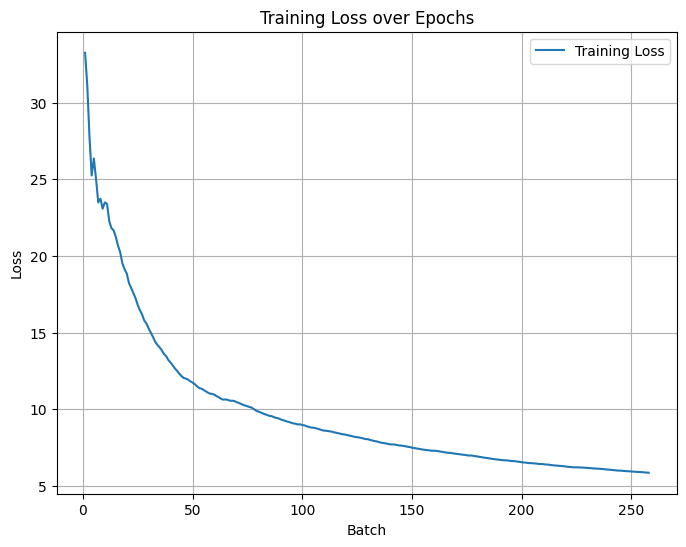

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Validation

In [25]:
val_df = pd.read_csv("/content/drive/MyDrive/val_pipeline.csv")
val_df = val_df.sample(1000)

In [26]:
val_text = []
val_image_links = []
val_labels = []

for index, row in val_df.iterrows():
  stri = f"""content: {row['content']}
    languages: {row['languages']}
    year: {row['year']}
    month: {row['month']}
    day_of_year: {row['day_of_year']}
    day_of_week: {row['day_of_week']}
    username: {row['username']}
    media_type: {row['media_type']}
    emoji_count: {row['emoji_count']}
    hashtag_count: {row['hastag_count']}
    uppercase_count: {row['uppercase_count']}
    at_count: {row['at_count']}
    sentiment_score: {row['sentiment_score']}
    subjectivity_score: {row['subjectivity_score']}
    word_count: {row['word_count']}
    image_size: {row['image_size']}
    """
  if row['image_url_status'] == "Link exists and is accessible":
    val_text.append(stri)
    val_image_links.append(row['image_url'])
    val_labels.append(np.log(1+row['likes']))
  if row['video_thumbnail_status'] == "Link exists and is accessible":
    val_text.append(stri)
    val_image_links.append(row['video_thumbnail_url'])
    val_labels.append(np.log(1+row['likes']))
  if row['gif_thumbnail_status'] == "Link exists and is accessible":
    val_text.append(stri)
    val_image_links.append(row['gif_thumbnail_url'])
    val_labels.append(np.log(1+row['likes']))

In [27]:
val_dataset = CustomDataset(val_text, val_image_links, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [28]:
len(val_loader)

62

In [29]:
from sklearn.metrics import mean_squared_error

model.eval()  # Set the model to evaluation mode

val_running_loss = 0.0
val_mse_sum = 0.0
val_div = 0

with torch.no_grad():  # No need to compute gradients during validation
    for val_batch_idx, (val_text, val_image, val_label) in enumerate(val_loader):
        if None not in val_text:
            val_outputs = model(val_text, val_image.to("cuda"))
            val_loss = criterion(val_outputs, torch.Tensor(val_label).type(torch.float32).unsqueeze(1).to("cuda"))
            val_running_loss += val_loss.item()

            val_mse = mean_squared_error(torch.Tensor(val_label).type(torch.float32).to("cpu"), val_outputs.squeeze(1).detach().to("cpu"))
            val_outputs = val_outputs.squeeze(1).detach().to("cpu")
            val_labels = torch.Tensor(val_label).type(torch.float32).to("cpu")
            for i in range(len(val_outputs)):
                val_mse_sum += (np.exp(val_outputs[i]) - np.exp(val_labels[i])) ** 2
            val_div += len(val_outputs)
            print(val_div)

    val_running_loss /= len(val_loader)
    val_mse_sum /= val_div
    val_rmse = np.sqrt(val_mse_sum)

    print(f"Validation Loss: {val_running_loss:.4f}, Validation RMSE: {val_rmse:.4f}")

16
32
48
64
80
96
112
128
144
160
176
192
208
224
240
256
272
288
304
320
336
352
368
384
400
416
432
448
464
480
496
512
528
544
560
576
592
608
624
640
656
672
688
704
720
736
752
768
784
800
816
832
848
864
880
896
912
928
944
960
976
986
Validation Loss: 3.2028, Validation RMSE: 3383.5327


In [30]:
val_div

986

In [31]:
val_mse

2.1987872

In [32]:
np.sqrt(val_mse_sum/val_div)

tensor(107.7536)

In [ ]:
val_mse /= val_div
val_rmse = np.sqrt(val_mse)

print(f"Validation Loss: {val_running_loss:.4f}, Validation RMSE: {val_rmse:.4f}")

Validation Loss: 1881.3902, Validation RMSE: 0.0213
